<a href="https://colab.research.google.com/github/jinayou/intro-numerical-methods/blob/master/ABMcore_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2023.12.17

- Trading preference formula: velocity adjusted (can adjust p_hold)
- Spreading preference:
    - Successful traders spread their trading strategies
    - Choose unique strategies from winning strategies (remove those already chosen)
    - When num of opinion groups increases, chose additional new preferences randomly
- Redistribution:
    - Redistribute preferences when opinion groups converge (can adjust redstribute_threshold %)
    - Does NOT use determine_distributed_earnings

In [ ]:
pip install mesa

In [ ]:
pip install powerlaw

In [ ]:
import mesa
import math
import random
import numpy as np
import copy

In [ ]:
class TraderAgent(mesa.Agent):

    def __init__(self, unique_id, model, p_hold):
        super().__init__(unique_id, model)
        self.trading_preference = self.velocity_adj_trading_preference(p_hold)
        self.latest_trading_decision = 0
        self.earnings = 0
        self.historical_earnings = []

    ## Trading prefrence formulas ##
    def dirichlet_trading_preference(self):
        return np.random.dirichlet(np.ones((3,), dtype=int), size=1)[0].tolist() # Choose 3 random nums that add up to 1

    def velocity_adj_trading_preference(self, p_hold): # Choose 2 random nums that add up to p_trade
        p_trade=1-p_hold
        p_buy=random.uniform(0, p_trade)
        p_sell=p_trade-p_buy
        return [p_buy, p_sell, p_hold]

    # Generate trading decisions based on probabilities
    def trade(self):
        decision = random.choices([1, -1, 0], weights=self.trading_preference, k=1)[0]
        #1=buy, -1=sell, 0=hold
        return decision


    def step(self):
        self.latest_trading_decision = self.trade()
        # self.historical_earnings.append(self.find_latest_earnings())

        # print(f"Agent {self.unique_id}'s trading preferences: {self.trading_preference}")
        # print(f"Agent {self.unique_id}'s trading decision: {self.latest_trading_decision}")


In [ ]:
class TradingModel(mesa.Model):

    def __init__(self, N, omega, sensitivity, p_hold, redistribute_threshold): #set self.p_hold = h
        self.num_agents = N
        self.schedule = mesa.time.RandomActivation(self)
        self.data_collector = mesa.datacollection.DataCollector(
            agent_reporters={"Latest Trading Decision": "latest_trading_decision"},
            model_reporters={"Traders' Decisions": "agent_decisions", "Returns": "returns_list"}
        )
        self.returns_list = [] #total return
        self.earnings_list = [] #for each agent
        self.latest_return = sum(agent.latest_trading_decision for agent in self.schedule.agents)*sensitivity
        self.p_hold = p_hold
        self.current_step=1
        self.previous_num_opinion_groups = N

        # Add the agent to the scheduler
        for i in range(self.num_agents):
            self.schedule.add(TraderAgent(i, self, p_hold))


    ## Trading prefrence formulas ##
    def dirichlet_trading_preference(self):
        return np.random.dirichlet(np.ones((3,), dtype=int), size=1)[0].tolist() # Choose 3 random nums that add up to 1

    def velocity_adj_trading_preference(self, p_hold): # Choose 2 random nums that add up to p_trade
        p_trade=1-p_hold
        p_buy=random.uniform(0, p_trade)
        p_sell=p_trade-p_buy
        return [p_buy, p_sell, p_hold]


    ## Earnings ##
    def update_agent_earnings_history(self):
        for agent in self.schedule.agents:
          agent.update_historical_earnings()

    def compile_earnings_list(self): #create a list of latest (non-distributed) earnings for all agents
        temp_list=[]
        for agent in self.schedule.agents:
          agent.earnings = -self.latest_return*agent.latest_trading_decision #choose which (buyer/seller) is the winner
          temp_list.append(agent.earnings)
        self.earnings_list = temp_list

    def determine_distributed_earnings(self): #returns
        num_profited = 0
        for agent in self.schedule.agents:
          if -agent.latest_trading_decision*self.latest_return > 0:  #choose which (buyer/seller) is the winner
            num_profited +=1
        # print('Number of Traders who Profited: ', num_profited)

        if num_profited !=0:
          distributed_return = abs(self.latest_return / num_profited)
        else:
          distributed_return = 0
        print('Distributed Return: ', distributed_return)

        return distributed_return

    ## Preferences ##
    def assign_new_preferences(self, total_r, p_hold, redistribute_threshold):

        #Determine number of opinion groups
        if total_r != 0:
            num_opinion_groups = int((self.num_agents / (abs(total_r)))**omega)
        else:
            num_opinion_groups = int(self.num_agents)
        # print("new number of opinion groups: ", num_opinion_groups)

        # Randomly distribute preferences onces opinion groups converge to a % of total traders.
        # Make this adaptable to each agent's earnings by using determine_distributed_earnings(self)
        if num_opinion_groups <= (self.num_agents*redistribute_threshold):
            print('Opinions have converged to', redistribute_threshold*100, '% of traders or less')
            for agent in self.schedule.agents:
              agent.trading_preference = agent.velocity_adj_trading_preference(self.p_hold)
            return
        else:
            self.spread_preferences(num_opinion_groups, p_hold)

    def spread_preferences(self, num_opinion_groups, p_hold):
    #Spread preferences based on whoever was successful in last iteration. If we run out of successful agents, create new preferences.

        self.compile_earnings_list()

        # Find indices of successful agents from last iteration
        successes = []

        for i in range(len(self.earnings_list)):
          if self.earnings_list[i] > 0:
            successes.append(i)

        trading_preferences = [] # Successful trading preferences

        # if number of opinion groups decreased, choose from winning strategies
        for i in range(min(num_opinion_groups, self.previous_num_opinion_groups)):
            if i < len(successes):
              # No overlap
              choice = successes.pop(random.randrange(len(successes)))
              trading_preferences.append(self.schedule.agents[choice].trading_preference)
            else:
              trading_preferences.append(self.velocity_adj_trading_preference(p_hold))

        # if number of opinion groups increases, append new random preference to make up difference
        for i in range(num_opinion_groups - self.previous_num_opinion_groups):
            trading_preferences.append(self.velocity_adj_trading_preference(p_hold))
        print(trading_preferences)

        self.previous_num_opinion_groups = num_opinion_groups

        # Assign agents evenly to the opinion groups
        for i in range(self.num_agents):
          self.schedule.agents[i].trading_preference = trading_preferences[i % num_opinion_groups]


    def step(self):
        print("-------------------------Beginning of step", self.current_step)
        self.current_step+=1

        # Advance the model by one step
        self.assign_new_preferences(self.latest_return/sensitivity, self.p_hold, redistribute_threshold)
        self.schedule.step()

        self.data_collector.collect(self)
        agent_decisions = [agent.latest_trading_decision for agent in self.schedule.agents]
        # print("Traders' Decisions:", agent_decisions)

        # Calculate and store the cumulative trading decisions from all agents
        self.latest_return = sum(agent.latest_trading_decision for agent in self.schedule.agents)*sensitivity
        print("Return:", self.latest_return)
        self.returns_list.append(self.latest_return)
        # print("Historical Returns:", self.returns_list)

        self.determine_distributed_earnings()

        self.compile_earnings_list()

In [ ]:
### RUN MODEL ###

## Parameters

#Sensitivity to price change
sensitivity = 1

#Power of omega term
omega = 1 #Check if omega is incorporated correctly

#Trading velocity
V=1.64
Vf=0.4
Vc=(V - 0.83*Vf)/(1- 0.83)
print(Vc)

#Daily trading probability
p=Vc/(250*2)
q=p
#h=1-p-q


## Run

p_hold=0.8
redistribute_threshold = 0.1

model = TradingModel(1000, omega, sensitivity, p_hold, redistribute_threshold) #Number of traders
for i in range(3627): #Number of time steps
    model.step()

print("Returns at Each Step:", model.returns_list)

#Test
# print(model.schedule.agents[1].historical_earnings)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
[[0.04972779579362766, 0.1502722042063723, 0.8], [0.11665213162798604, 0.08334786837201391, 0.8], [0.023514880872153206, 0.17648511912784676, 0.8], [0.04647023642172198, 0.15352976357827797, 0.8], [0.06840673735776617, 0.13159326264223378, 0.8], [0.05358757618911728, 0.14641242381088268, 0.8], [0.0038391396903474364, 0.19616086030965252, 0.8], [0.02446162403933469, 0.17553837596066527, 0.8], [0.05640935412080824, 0.1435906458791917, 0.8], [0.057838200099669564, 0.1421617999003304, 0.8], [0.12761746573152316, 0.0723825342684768, 0.8], [0.11683150705379992, 0.08316849294620003, 0.8], [0.14428203990281127, 0.055717960097188685, 0.8], [0.01227415973037411, 0.18772584026962585, 0.8], [0.04640732547611374, 0.15359267452388622, 0.8], [0.01099819341982113, 0.18900180658017882, 0.8], [0.011236077442397227, 0.18876392255760271, 0.8], [0.03808536617279147, 0.1619146338272085, 0.8], [0.062414838505058745, 0.1375851614949

In [ ]:
output_returns = model.returns_list

ANALYSIS

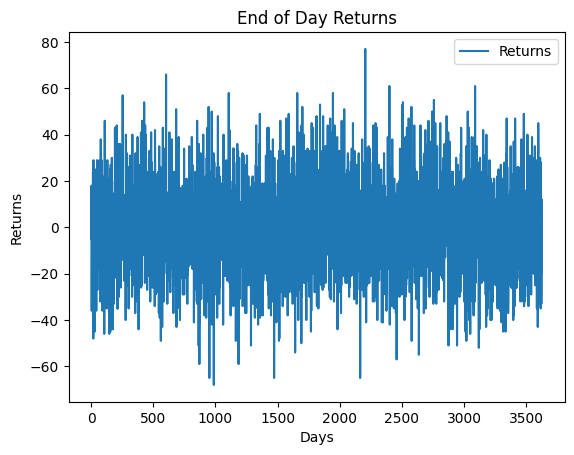

<ipython-input-9-247111232a42>:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(output_returns, hist=True, kde=False,


[2, 12, 5, 18, 6, 36, 14, 7, 10, 8, 15, 15, 3, 30, 12, 24, 14, 7, 48, 29, 2, 24, 25, 8, 28, 14, 16, 5, 3, 45, 8, 5, 3, 4, 3, 24, 2, 15, 25, 3, 3, 8, 36, 7, 19, 8, 2, 14, 29, 13, 5, 27, 4, 14, 18, 17, 2, 7, 26, 12, 14, 4, 8, 15, 17, 16, 7, 29, 24, 5, 5, 24, 4, 32, 6, 17, 6, 13, 38, 7, 32, 10, 16, 10, 29, 20, 4, 12, 5, 9, 33, 36, 23, 22, 12, 13, 11, 10, 8, 6, 10, 10, 12, 20, 19, 8, 46, 2, 2, 7, 46, 17, 2, 26, 4, 9, 2, 8, 15, 4, 14, 4, 17, 4, 2, 2, 35, 26, 13, 17, 7, 29, 2, 7, 12, 2, 4, 21, 15, 10, 16, 4, 17, 10, 13, 9, 46, 15, 3, 20, 13, 28, 11, 25, 7, 45, 6, 40, 27, 8, 35, 3, 11, 2, 2, 2, 2, 30, 14, 20, 27, 3, 5, 5, 13, 44, 13, 31, 2, 23, 2, 15, 5, 33, 3, 2, 13, 3, 22, 4, 15, 8, 43, 3, 16, 15, 5, 14, 2, 13, 21, 5, 8, 21, 6, 8, 44, 6, 8, 10, 5, 35, 4, 35, 14, 12, 7, 8, 36, 2, 2, 10, 14, 9, 30, 14, 19, 5, 6, 16, 3, 10, 8, 36, 11, 2, 14, 7, 2, 12, 26, 6, 12, 6, 31, 11, 6, 12, 12, 3, 8, 35, 14, 8, 57, 18, 2, 10, 3, 2, 5, 10, 14, 2, 3, 23, 6, 14, 3, 10, 2, 13, 6, 19, 2, 6, 5, 5, 40, 3, 40, 3

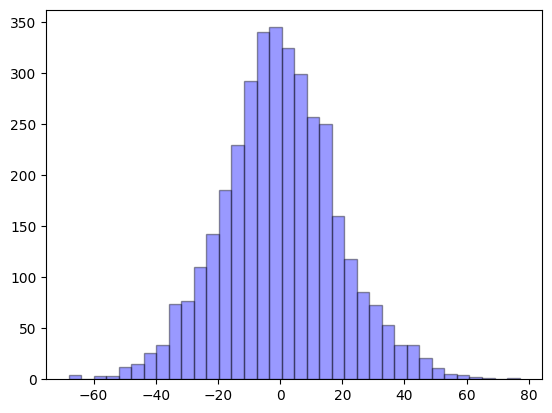

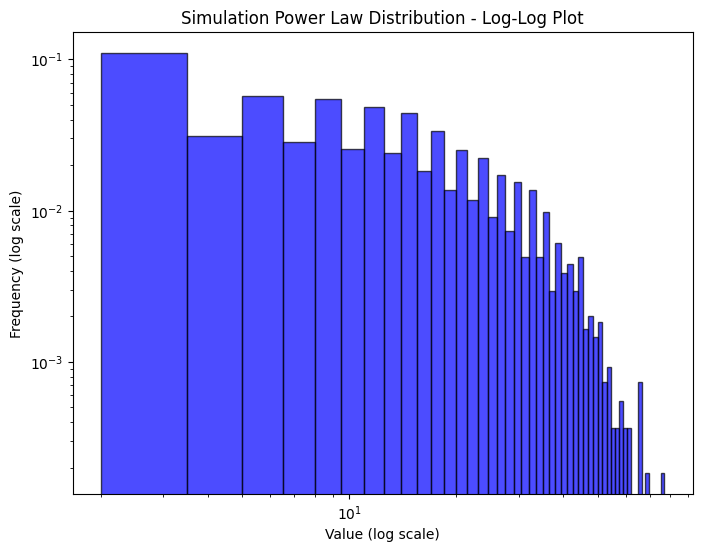

[INFO] computing Hill Estimators...
2

Sample size n: 3627
Total number of exceeded k: 3626


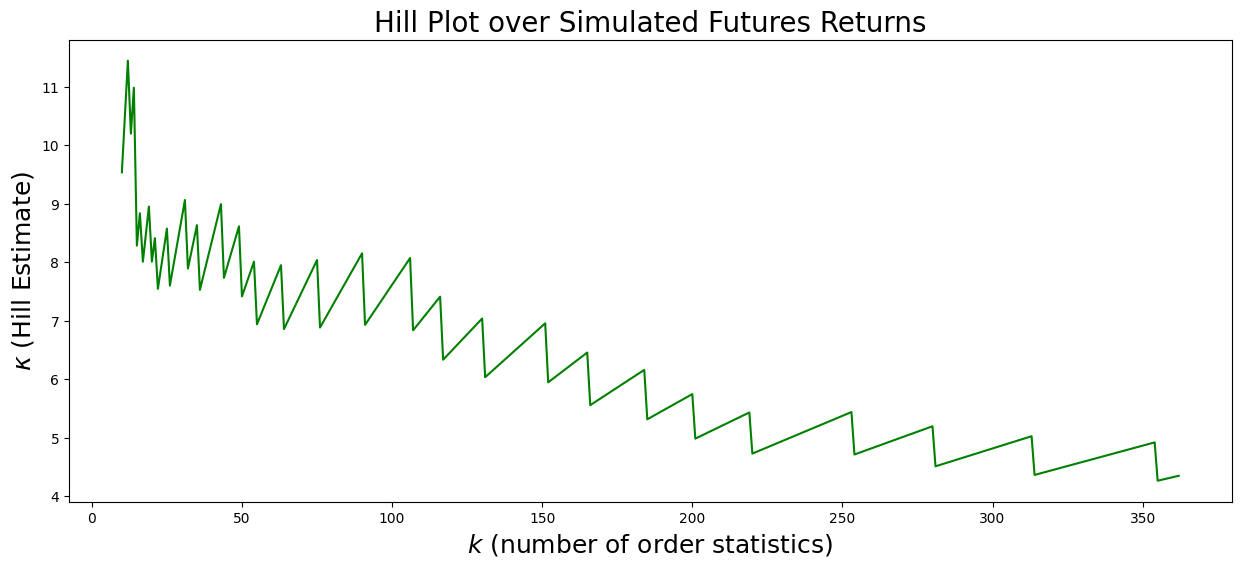

In [ ]:
import matplotlib.pyplot as plt
import powerlaw
import pandas as pd
import seaborn as sns

## PLOT SIMULATION ##

# Plot returns
plt.plot(output_returns, label='Returns')
plt.xlabel('Days')
plt.ylabel('Returns')
plt.title('End of Day Returns')
plt.legend()
plt.show()

# Histogram
sns.distplot(output_returns, hist=True, kde=False,
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

#Option 1
'''data=[]
for i in output_returns:
  data.append(abs(i))
print(data)'''

#Option 2
data=[]
for i in output_returns:
  if abs(i)<2:
    data.append(2)
  else:
    data.append(abs(i))
print(data)

#Option 3
'''data=[]
for i in output_returns:
  if i== 0:
    data.append(0.1)
  else:
    data.append(abs(i))
print(data)'''


# Plot returns on a log-log scale
plt.figure(figsize=(8, 6))
plt.hist(data, bins=50, density=True, alpha=0.7, color='blue', edgecolor = 'black')
plt.xscale('log')
plt.yscale('log')
plt.title('Simulation Power Law Distribution - Log-Log Plot')
plt.xlabel('Value (log scale)')
plt.ylabel('Frequency (log scale)')
plt.show()



### Hill Estimator FOR SIMULATION
# code found on GitHub under the profile AlinaSode

def Hill_estimator(data):
    """
    Returns the Hill Estimators for some 1D data set.
    """
    # sort data in such way that the smallest value is first and the largest value comes last:
    Y = np.sort(data)
    n = len(Y)

    Hill_est = np.zeros(n-1)

    for k in range(0, n-1):    # k = 0,...,n-2
        summ = 0

        for i in range(0,k+1):   # i = 0, ..., k
            summ += np.log(Y[n-1-i]) - np.log(Y[n-2-k])

        Hill_est[k] = (1 / (k+1)) * summ      # add 1 to k because of Python syntax

    kappa = 1. / Hill_est
    return kappa


n_obs = len(data)
k_max = int(round(0.1*n_obs))
k_min = 10

print("[INFO] computing Hill Estimators...")
#t0 = time()
print(min(data))
kap_gains_sim = Hill_estimator(data)

#print ("        done in %0.3f minutes" % ((time() - t0)/60))
print ("")

print ("Sample size n:", n_obs)
print ("Total number of exceeded k:", len(kap_gains_sim))


""" Hill Plot for Gains for k in range (10,...,round(0.1*n_obs)) """

plt.figure(figsize=(15, 6))
plt.plot(np.arange(k_min,k_max), kap_gains_sim[k_min-1:k_max-1], 'green')
plt.xlabel("$k$ (number of order statistics)", fontsize=18)
plt.ylabel("$\kappa$ (Hill Estimate)", fontsize=18)
plt.title("Hill Plot over Simulated Futures Returns", fontsize=20)
plt.show()

            Date  Price   Open   High    Low     Vol. Change % Return
0     12/05/2023  2.748  2.702  2.785  2.678             2.00%   0.02
1     12/04/2023  2.694  2.728  2.752  2.649  161.79K   -4.26%  -0.04
2     12/01/2023  2.814  2.809  2.844  2.754  133.19K    0.43%   0.00
3     11/30/2023  2.802  2.799  2.855  2.761  147.75K   -0.07%   0.00
4     11/29/2023  2.804  2.792   2.87   2.76  141.59K    3.62%   0.04
...          ...    ...    ...    ...    ...      ...      ...    ...
3623  01/08/2010  5.749  5.827  5.853  5.621  101.15K   -0.98%  -0.01
3624  01/07/2010  5.806  6.033  6.108  5.763  135.11K   -3.38%  -0.03
3625  01/06/2010  6.009   5.69  6.075   5.65  140.61K    6.60%   0.07
3626  01/05/2010  5.637  5.837  5.858  5.615   99.49K   -4.20%  -0.04
3627  01/04/2010  5.884  5.705  5.894  5.705   78.86K    5.60%   0.06

[3628 rows x 8 columns]
0       0.0200
1       0.0426
2       0.0043
3       0.0007
4       0.0362
         ...  
3623    0.0098
3624    0.0338
3625    0.0660


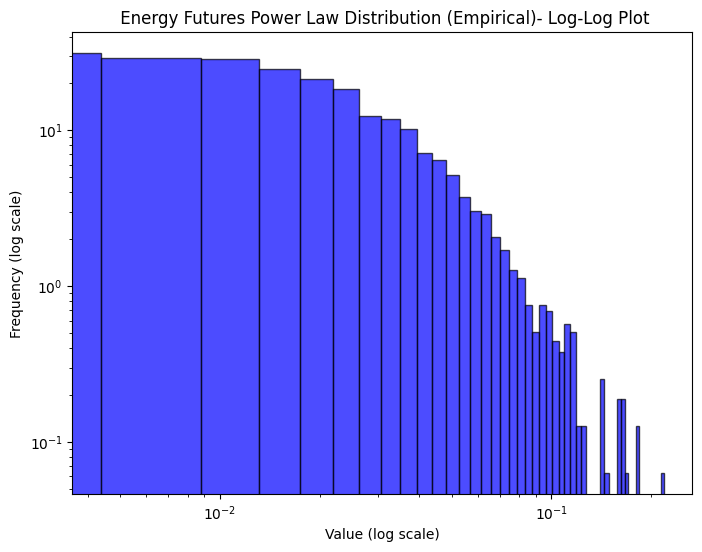

In [ ]:
## READ IN NATURAL GAS FUTURES DATA

## Load data from the drive

from google.colab import auth
auth.authenticate_user()

import gspread

# method 1
from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)

gsheets = gc.open_by_url('https://docs.google.com/spreadsheets/d/1VMZvoSCBruftaPjW7XwjlsjZBfLdOQ3BKNY2WiC46eE/edit?usp=drive_link')
sheets = gsheets.worksheet('Natural Gas Futures Historical Data').get_all_values()
futures_data = pd.DataFrame(sheets[1:], columns=sheets[0])

# method 2
'''
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)

#Path to the data will likely change for you
path = "/content/drive/MyDrive/ABMcore/Data/Gas_futures_data.gsheet"

futures_data=pd.read_csv(path)
'''

print(futures_data)

futures_data["Change"] = futures_data['Change %'].str.rstrip('%').astype('float') / 100.0
fdata = futures_data["Change"].abs()

print(fdata)

## PLOT NATURAL GAS FUTURES DATA
# Plot the data on a log-log scale
plt.figure(figsize=(8, 6))
plt.hist(fdata, bins=50, density=True, alpha=0.7, color='blue', edgecolor = 'black')
plt.xscale('log')
plt.yscale('log')
plt.title(' Energy Futures Power Law Distribution (Empirical)- Log-Log Plot')
plt.xlabel('Value (log scale)')
plt.ylabel('Frequency (log scale)')
plt.show()


[INFO] computing Hill Estimators...


<ipython-input-9-247111232a42>:75: RuntimeWarning: divide by zero encountered in log
  summ += np.log(Y[n-1-i]) - np.log(Y[n-2-k])
<ipython-input-9-247111232a42>:75: RuntimeWarning: invalid value encountered in double_scalars
  summ += np.log(Y[n-1-i]) - np.log(Y[n-2-k])



Sample size n: 3628
Total number of exceeded k: 3627


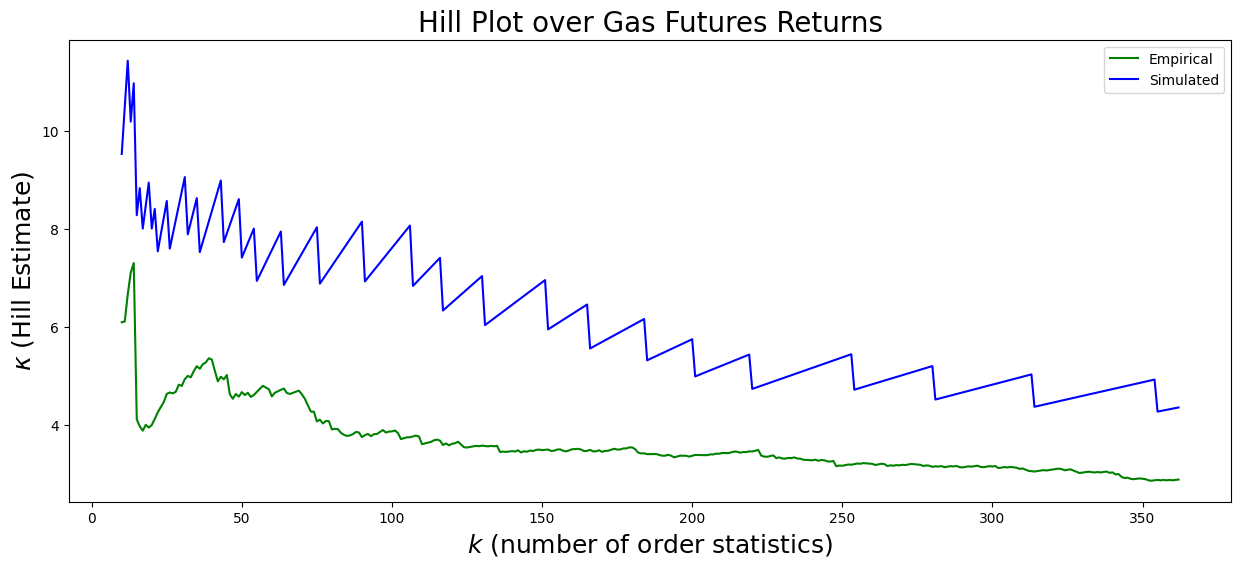

[ 8.04520008 10.86935002 13.05448607 17.40598142 21.75747678  9.82179187
 11.45875719  9.1160003  10.25550034  9.53723259 10.49095585 11.44467911
 10.19915942 10.98371014  8.28552547  8.83789383  8.01009671  8.48127887
  8.95246103  8.01229374  8.41290843  7.54658889  7.88961566  8.23264243
  8.57566919  7.60212885  7.89451842  8.18690799  8.47929756  8.77168713
  9.0640767   7.8938695   8.14055292  8.38723634  8.63391976  7.52968553
  7.73884347  7.9480014   8.15715933  8.36631726  8.57547519  8.78463312
  8.99379106  7.73514199  7.91094067  8.08673936  8.26253804  8.43833672
  8.6141354   7.41730236  7.5656484   7.71399445  7.8623405   8.01068654
  6.9410821   7.06728359  7.19348509  7.31968658  7.44588807  7.57208956
  7.69829106  7.82449255  7.95069404  6.85923499  6.96641054  7.07358609
  7.18076163  7.28793718  7.39511273  7.50228827  7.60946382  7.71663937
  7.82381491  7.93099046  8.03816601  6.88504107  6.97563372  7.06622636
  7.15681901  7.24741166  7.3380043   7.42859695  7

In [ ]:
## HILL ESTMATOR FOR GAS FUTURES ##

n_obs = len(fdata)
k_max = int(round(0.1*n_obs))
k_min = 10

print("[INFO] computing Hill Estimators...")
#t0 = time()

kap_gains = Hill_estimator(fdata)


print ("")

print ("Sample size n:", n_obs)
print ("Total number of exceeded k:", len(kap_gains))


""" Hill Plot for Gains for k in range (10,...,round(0.1*n_obs)) """

plt.figure(figsize=(15, 6))
plt.plot(np.arange(k_min,k_max), kap_gains[k_min-1:k_max-1], 'green', label = 'Empirical')
plt.plot(np.arange(k_min,k_max), kap_gains_sim[k_min-1:k_max-1], 'blue', label = 'Simulated')
plt.legend()
plt.xlabel("$k$ (number of order statistics)", fontsize=18)
plt.ylabel("$\kappa$ (Hill Estimate)", fontsize=18)
plt.title("Hill Plot over Gas Futures Returns", fontsize=20)
plt.show()
print(kap_gains_sim[0:100])
print(kap_gains[0:100])
print('kap_gains_sim', kap_gains_sim[72])
ratio = []
for i in range(100):
  ratio.append(kap_gains_sim[i]/kap_gains[i])
print(ratio)